# 1 Loading Data

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
RANDOM_STATE = 42

%matplotlib inline 

train_text_df = pd.read_csv('../datasets/training_text/training_text', sep='\|\|', engine='python', skiprows=1, names=['ID', 'Text'])
print(train_text_df.shape)
submission_text_df = pd.read_csv('../datasets/test_text/test_text', sep='\|\|', engine='python', skiprows=1, names=['ID', 'Text'])
print(submission_text_df.shape)
train_text_column = train_text_df['Text']
submission_text_column = submission_text_df['Text']
# grouping all texts
text_column = np.append(train_text_column, submission_text_column)

# load features
training_features_df = pd.read_csv('../datasets/training_variants/training_variants', sep=',')
submission_features_df = pd.read_csv('../datasets/test_variants/test_variants', sep=',')

# load labels
training_labels = training_features_df['Class']
training_labels = pd.Series(np.array([i-1 for i in training_labels]), name='Class')

(3321, 2)
(5668, 2)


# 2 Data Cleaning

In [2]:
from nltk.corpus import stopwords
import nltk.data
import re

# English stop words
stops = set(stopwords.words("english"))
clean_text_column = []

# for debug, can handle corpus line by line
def get_text_lines_generator():
    for text in text_column:
        # Remove non-letters/digits
        text  = re.sub("[^a-zA-Z0-9]"," ", text)
        # Convert words to lower case
        words = text.lower().split()
        words = [w for w in words if not w in stops]
        yield ' '.join(words)
text_lines_generator = get_text_lines_generator()

for i in tqdm(range(len(text_column))):
    next_line = text_lines_generator.__next__()
    clean_text_column.append(next_line)

100%|█████████████████████████████████████████████████████████████████████████████| 8989/8989 [00:45<00:00, 197.44it/s]


# 3 Prepare Word Vectors

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

vectorizer = TfidfVectorizer(analyzer="word", ngram_range=(1, 2), tokenizer=nltk.word_tokenize)

start = time()
text_tfid = vectorizer.fit_transform(clean_text_column)
print('tf-idf duration', time() - start, 'seconds')

tfid_svd = TruncatedSVD(n_components = 150, n_iter=100)
start = time()
truncated_text_tfid = tfid_svd.fit_transform(text_tfid)
print('TruncatedSVD duration', time() - start, 'seconds')

tf-idf duration 453.23452734947205 seconds
TruncatedSVD duration 8216.112476587296 seconds


In [4]:
truncated_text_tfid_train = truncated_text_tfid[:train_text_df.shape[0]]
truncated_text_tfid_submission = truncated_text_tfid[train_text_df.shape[0]:]
print(truncated_text_tfid_train.shape)
print(truncated_text_tfid_submission.shape)

(3321, 150)
(5668, 150)


In [5]:
print('Raw:', text_column[0][:60])
print('Clean:', clean_text_column[0][:60])
print('tf-idf vector:', text_tfid[0].shape)
print('Truncated tf-idf vector:', truncated_text_tfid[0].shape)

Raw: Cyclin-dependent kinases (CDKs) regulate a variety of fundam
Clean: cyclin dependent kinases cdks regulate variety fundamental c
tf-idf vector: (1, 5371667)
Truncated tf-idf vector: (150,)


# 4 Encode gene & variation

## 4.1 tf-idf gene

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
import nltk

# tf-idf gene
vectorizer = TfidfVectorizer(analyzer="char", 
                             ngram_range=(1, 10))
# vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 10))

start = time()
tfidf_gene = vectorizer.fit_transform(training_features_df['Gene'].append(submission_features_df['Gene']))
print('tf-idf duration', time() - start, 'seconds')
print(tfidf_gene.shape)

svd = TruncatedSVD(n_components=20, n_iter=100)
start = time()
truncated_tfidf_gene = svd.fit_transform(tfidf_gene)
print('TruncatedSVD duration', time() - start, 'seconds')

print(truncated_tfidf_gene.shape)

# create data frame
encoded_training_gene_df = pd.DataFrame(columns=['gene'+str(i) for i in range(0, 20)])
encoded_submission_gene_df = pd.DataFrame(columns=['gene'+str(i) for i in range(0, 20)])

for i in tqdm(range(0, train_text_df.shape[0])):
    encoded_training_gene_df.loc[i] = truncated_tfidf_gene[i]

for i in tqdm(range(train_text_df.shape[0], truncated_tfidf_gene.shape[0])):
    encoded_submission_gene_df.loc[i] = truncated_tfidf_gene[i]
    
# set data type
encoded_training_gene_df = encoded_training_gene_df.astype(float)
encoded_submission_gene_df = encoded_submission_gene_df.astype(float)  

print(encoded_training_gene_df.shape)
print(encoded_submission_gene_df.shape)

tf-idf duration 0.33164143562316895 seconds
(8989, 8042)
TruncatedSVD duration 1.9133837223052979 seconds
(8989, 20)


100%|█████████████████████████████████████████████████████████████████████████████| 5668/5668 [00:08<00:00, 672.83it/s]


(3321, 20)
(5668, 20)


## 4.2 tf-idf Variation

In [7]:
# tf-idf variations
vectorizer = TfidfVectorizer(analyzer="char", 
                             ngram_range=(1, 10))

# vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 10))

start = time()
tfidf_variation = vectorizer.fit_transform(training_features_df['Variation'].append(submission_features_df['Variation']))
print('tf-idf duration', time() - start, 'seconds')
print(tfidf_variation.shape)

svd = TruncatedSVD(n_components=20, n_iter=100)


start = time()
truncated_tfidf_variation = svd.fit_transform(tfidf_variation)
print('TruncatedSVD duration', time() - start, 'seconds')

print(truncated_tfidf_variation.shape)

# create data frame
encoded_training_variation_df = pd.DataFrame(columns=['variation_'+str(i) for i in range(0, 20)])
encoded_submission_variation_df = pd.DataFrame(columns=['variation_'+str(i) for i in range(0, 20)])

for i in tqdm(range(0, train_text_df.shape[0])):
    encoded_training_variation_df.loc[i] = truncated_tfidf_variation[i]

for i in tqdm(range(train_text_df.shape[0], truncated_tfidf_variation.shape[0])):
    encoded_submission_variation_df.loc[i] = truncated_tfidf_variation[i]
    
# set data type
encoded_training_variation_df = encoded_training_variation_df.astype(float)
encoded_submission_variation_df = encoded_submission_variation_df.astype(float)  

print(encoded_training_variation_df.shape)
print(encoded_submission_variation_df.shape)

tf-idf duration 0.28716373443603516 seconds
(8989, 45001)
TruncatedSVD duration 6.415066242218018 seconds
(8989, 20)


100%|█████████████████████████████████████████████████████████████████████████████| 5668/5668 [00:08<00:00, 676.25it/s]


(3321, 20)
(5668, 20)


In [8]:
# encoded_features = encoded_variation_df.join(one_hot_gene) 
encoded_training_features = encoded_training_variation_df.join(encoded_training_gene_df)
encoded_submission_features = encoded_submission_variation_df.join(encoded_submission_gene_df)
print(encoded_training_features.shape)
print(encoded_submission_features.shape)

(3321, 40)
(5668, 40)


# 5 Oversampling methods

In [79]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, f1_score

In [130]:
import seaborn as sn
def plot_confusion_matrix(clf, X, y):
    pred = clf.predict(X)
    cm = confusion_matrix(y, pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = [i+1 for i in range(0, 9)],
                      columns = [i+1 for i in range(0, 9)])
    plt.figure(figsize = (10,7))
    hmap = sn.heatmap(df_cm, annot=True)
    hmap.set_title('Confusion Matrix')
    hmap.set_xlabel('Predictions')
    hmap.set_ylabel('True labels')

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler 
import lightgbm as lgb
from collections import Counter
    

tf_idf_X = np.array(encoded_training_features.join(pd.DataFrame(truncated_text_tfid_train)))
tf_idf_X_submit = np.array(encoded_submission_features.reset_index().join(pd.DataFrame(truncated_text_tfid_submission)).drop('index', 1))
print(tf_idf_X.shape)
print(tf_idf_X_submit.shape)


def quick_train_K_fold_CV(X, Y, folds, resampler):
    # make sure class distribution
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)

    skf_losses = []
    f1s = []
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        if resampler:
            X_train, y_train = resampler.fit_sample(X_train, y_train)
        
        tf_idf_clf = lgb.LGBMClassifier(
            n_estimators= 10000, # will be stopped by early_stopping_rounds
            objective = 'multiclass',
            num_class = 9
            )
  
        tf_idf_clf.fit(X_train, y_train, 
                        verbose = False,
                        early_stopping_rounds = 300,
                        eval_set= [(X_train, y_train), (X_test, y_test)])
    
        test_log_loss = log_loss(y_test, tf_idf_clf.predict_proba(X_test))
        f1 = f1_score(y_test, tf_idf_clf.predict(X_test), average='weighted')
        print(len(skf_losses), test_log_loss, f1)
        skf_losses.append(test_log_loss)
        f1s.append(f1)
        plot_confusion_matrix(tf_idf_clf, X_test, y_test)
        lgb.plot_metric(clf_random_resampled)
    print('avg. loss', np.mean(skf_losses))
    print('avg. f1', np.mean(f1))
    return tf_idf_clf




(3321, 190)
(5668, 190)


C:\Users\kingy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0 0.961912615256 0.665727991776


C:\Users\kingy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1 0.879833622065 0.686766472442
2 0.891326175377 0.697815511535
3 0.925800653559 0.66497057304


C:\Users\kingy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


4 0.902877939839 0.672562869033
avg. loss 0.912350201219
avg. f1 0.672562869033


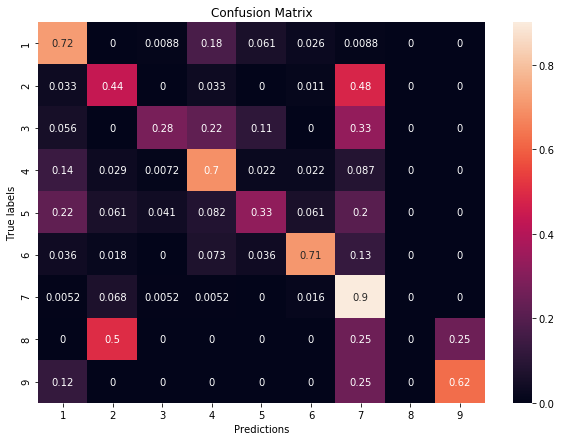

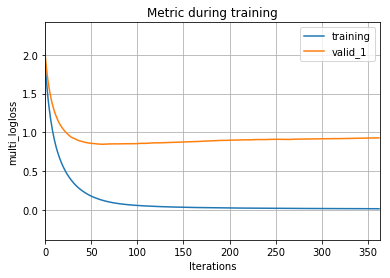

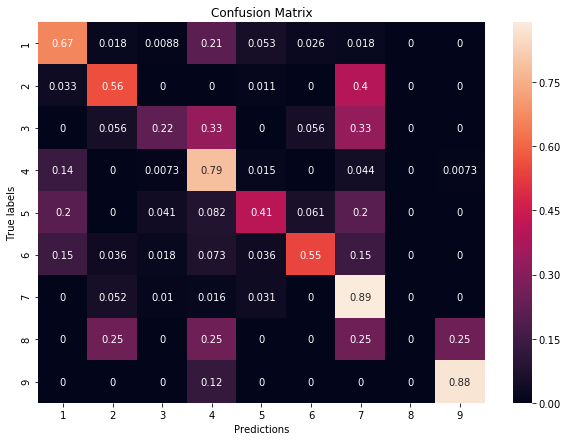

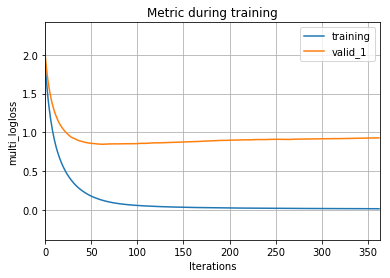

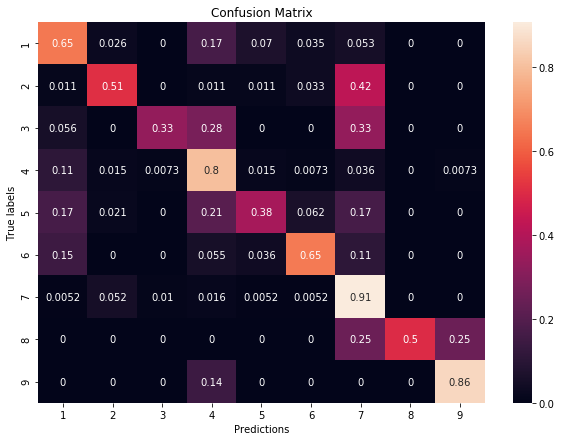

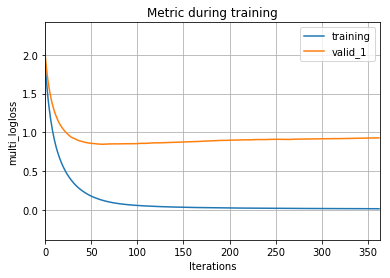

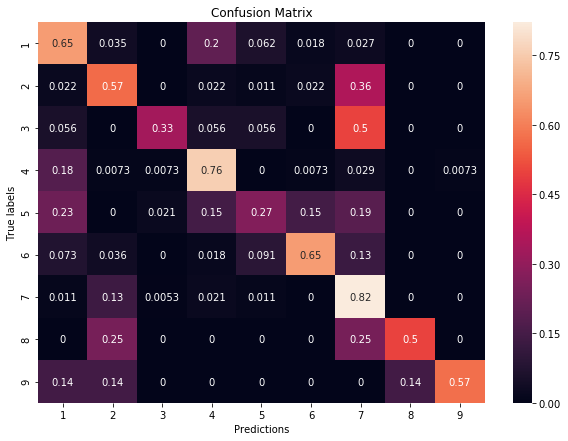

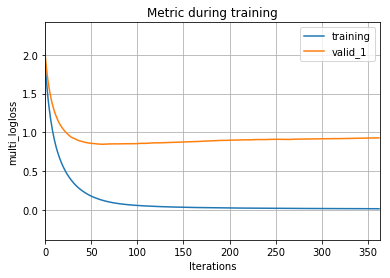

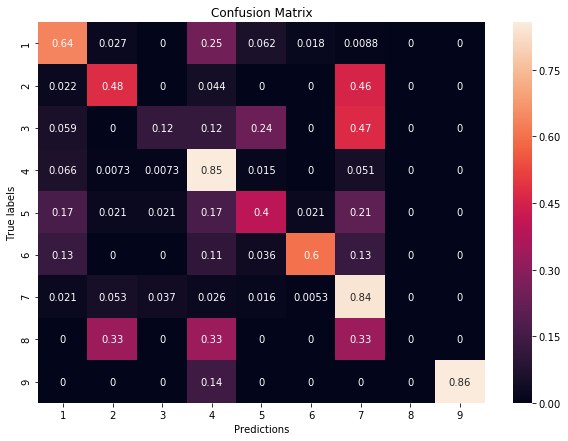

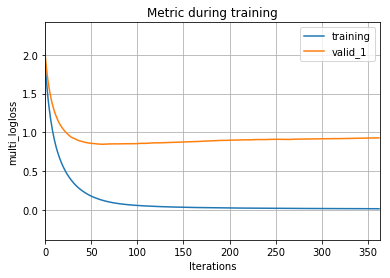

In [90]:
clf = quick_train_K_fold_CV(tf_idf_X, training_labels, 5, None)

## RandomOverSampler

0 0.990993938856 0.661388508865
1 0.871869695594 0.684868205348
2 0.896631450295 0.692979304659
3 0.936846795612 0.675328062815


C:\Users\kingy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


4 0.917323527867 0.682537492135
avg. loss 0.922733081645
avg. f1 0.682537492135


LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10000,
        nthread=-1, num_class=9, num_leaves=31, objective='multiclass',
        reg_alpha=0, reg_lambda=0, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

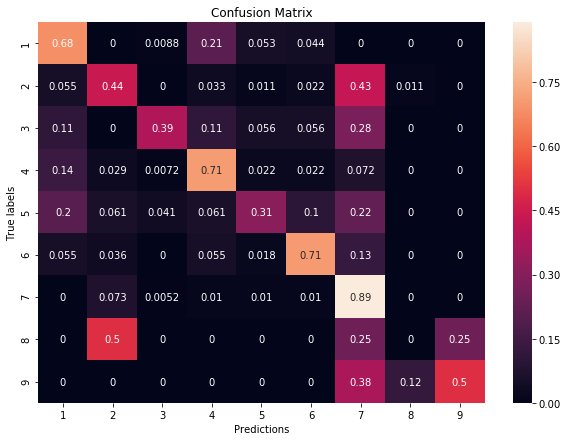

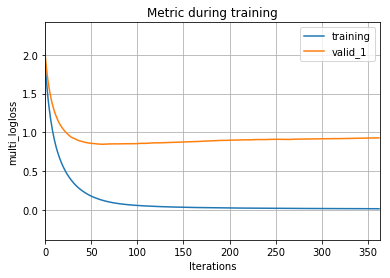

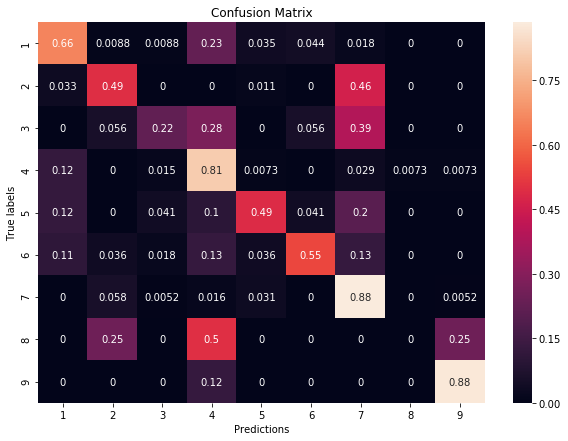

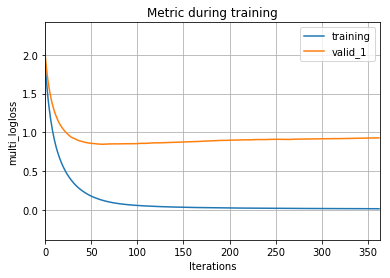

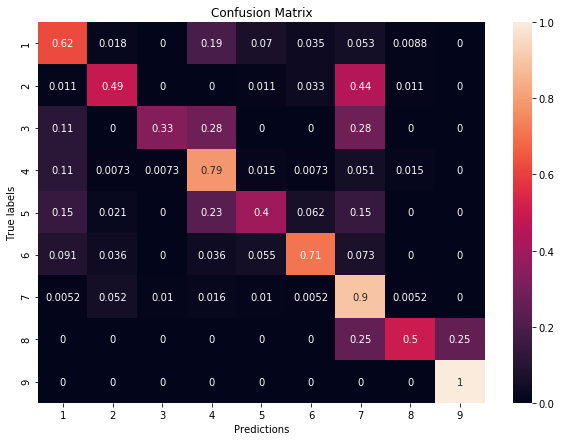

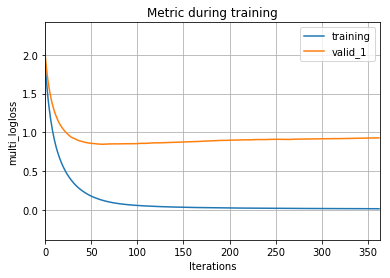

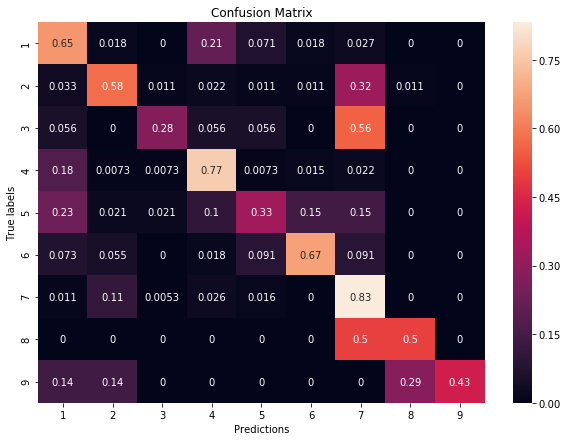

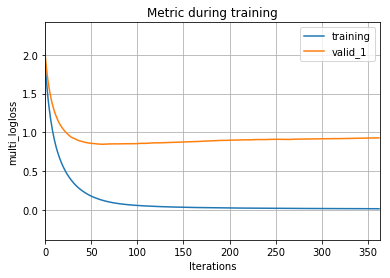

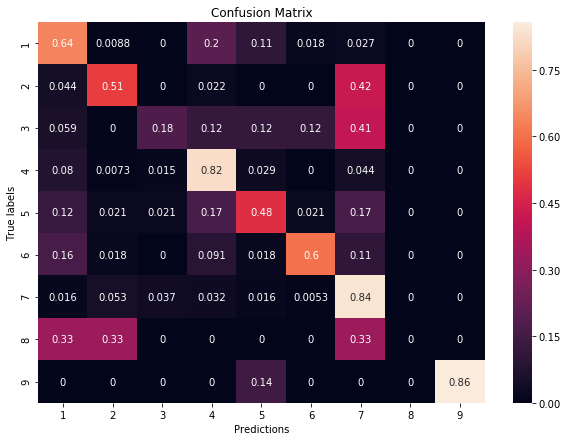

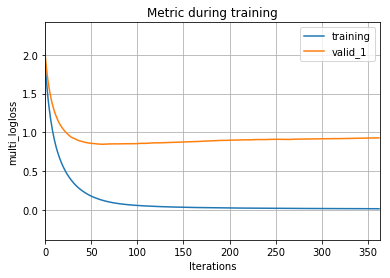

In [91]:
quick_train_K_fold_CV(tf_idf_X, training_labels, 5, RandomOverSampler(ratio='minority', random_state=RANDOM_STATE))

## SMOTE{'regular', 'borderline1', 'borderline2', 'svm'} 

0 0.984552245161 0.653529289719
1 0.84440048703 0.699103825273
2 0.888758959365 0.698113735314
3 0.921408188026 0.689450862164
4 0.904870049364 0.681926792311
avg. loss 0.908797985789
avg. f1 0.681926792311


LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10000,
        nthread=-1, num_class=9, num_leaves=31, objective='multiclass',
        reg_alpha=0, reg_lambda=0, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

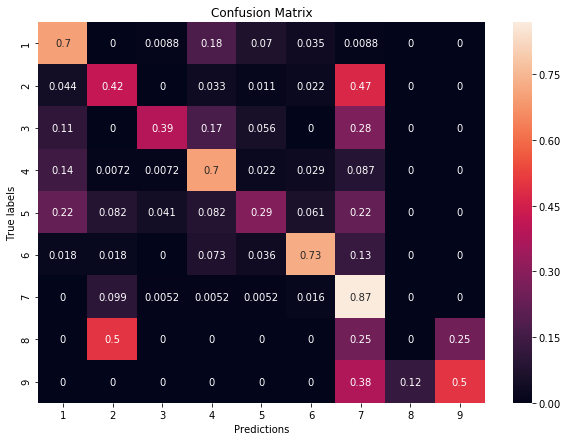

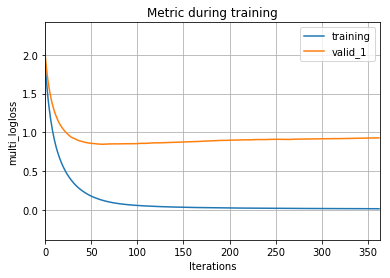

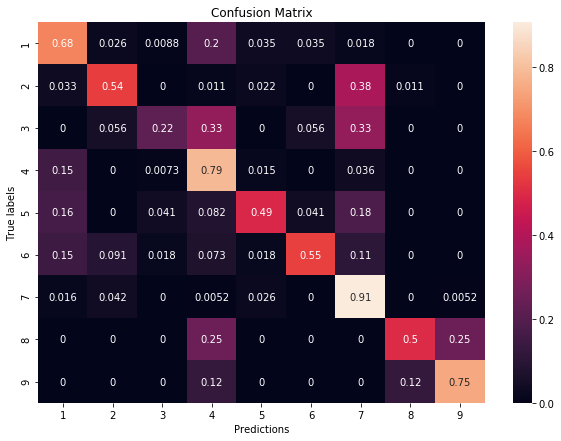

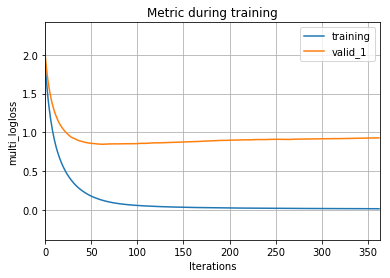

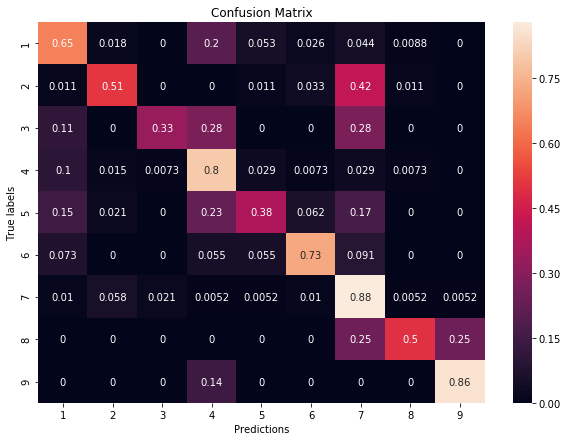

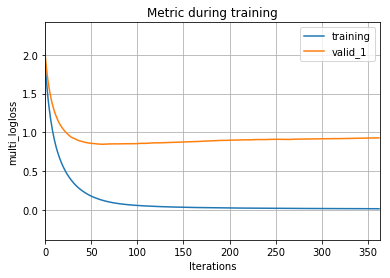

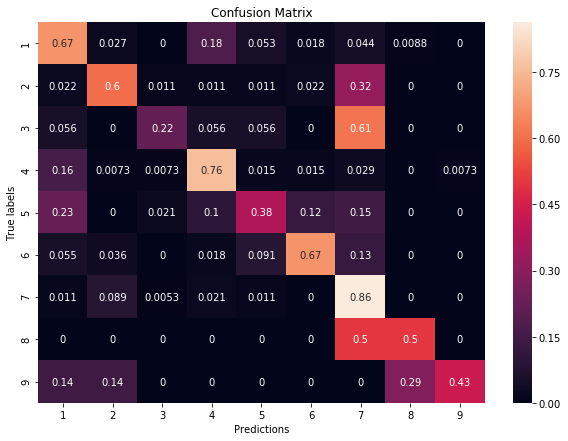

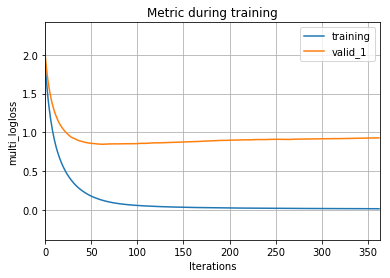

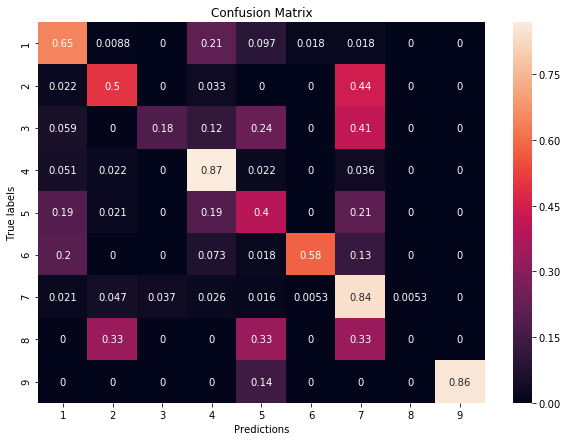

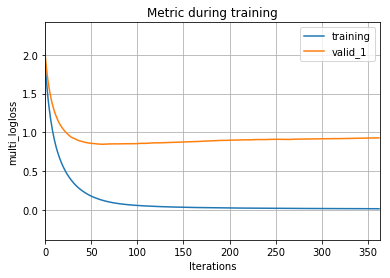

In [92]:
quick_train_K_fold_CV(tf_idf_X, training_labels, 5, SMOTE(ratio='minority', random_state=RANDOM_STATE))

## ADASYN

0 0.958710455118 0.668042552806
1 0.87435506052 0.689679879395
2 0.87706883452 0.69084600911
3 0.917943689832 0.690407102528
4 0.903512146827 0.684525429778
avg. loss 0.906318037363
avg. f1 0.684525429778


LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10000,
        nthread=-1, num_class=9, num_leaves=31, objective='multiclass',
        reg_alpha=0, reg_lambda=0, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

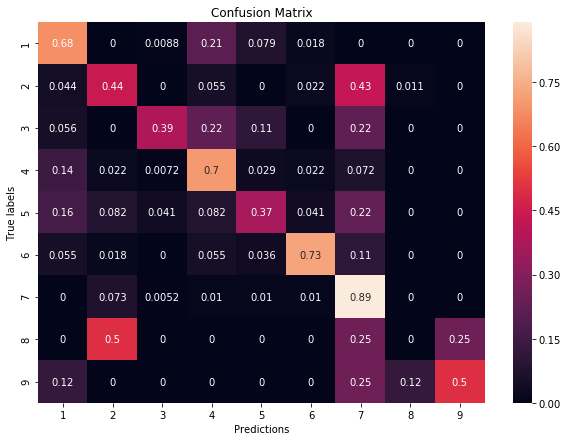

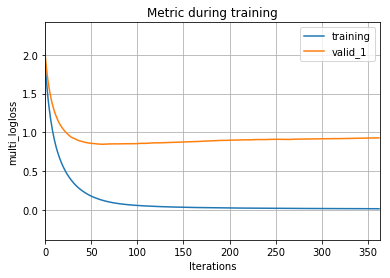

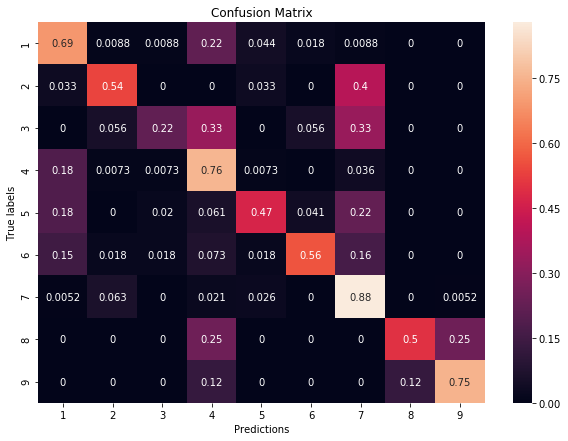

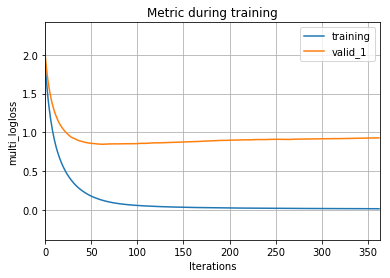

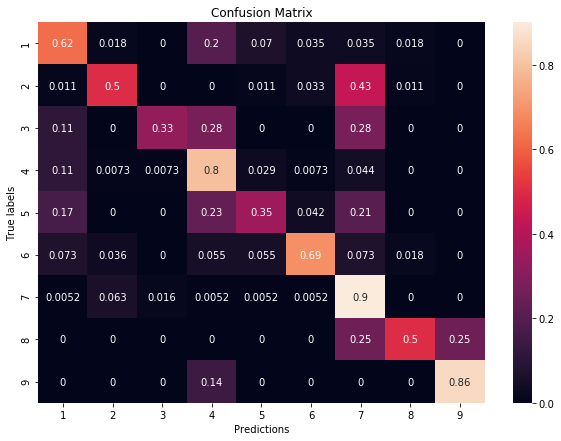

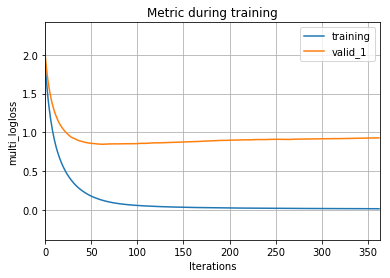

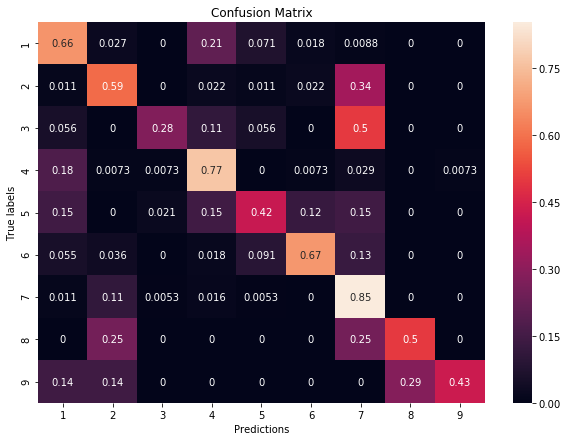

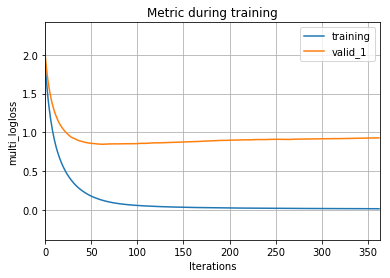

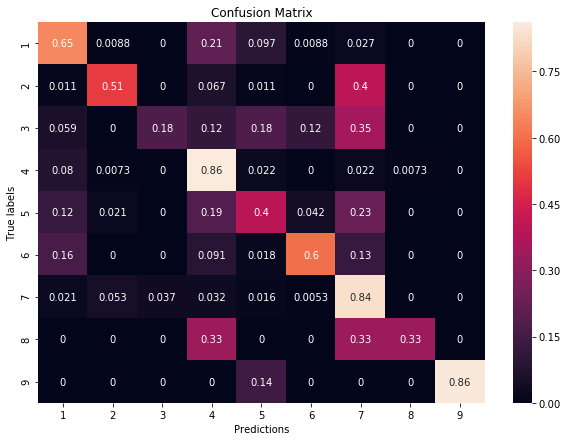

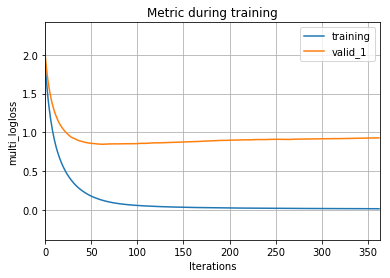

In [93]:
quick_train_K_fold_CV(tf_idf_X, training_labels, 5, ADASYN(ratio='minority', random_state=RANDOM_STATE))

## Final Model

0 0.984552245161 0.653529289719
1 0.84440048703 0.699103825273
2 0.888758959365 0.698113735314
3 0.921408188026 0.689450862164
4 0.904870049364 0.681926792311


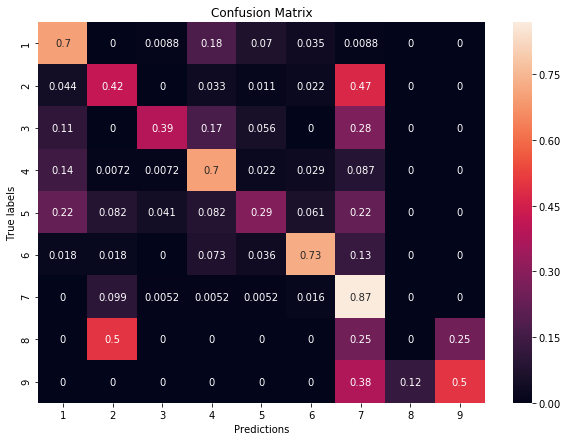

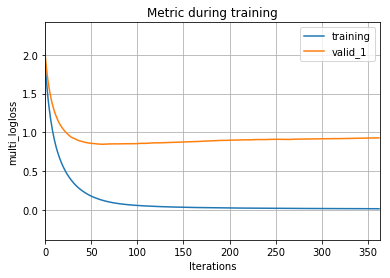

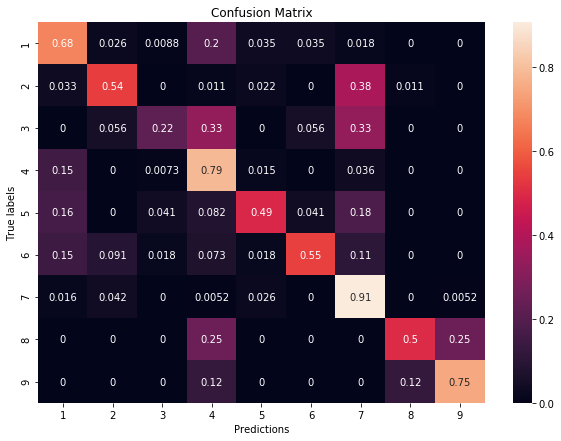

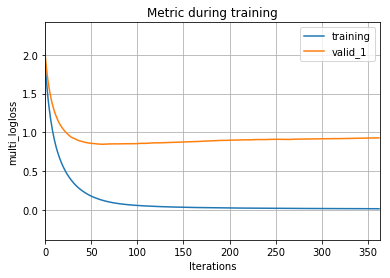

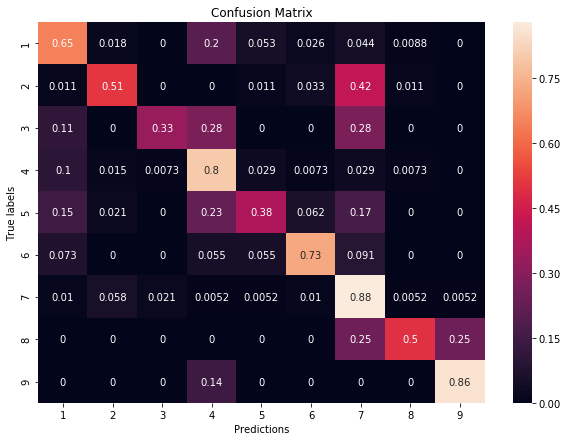

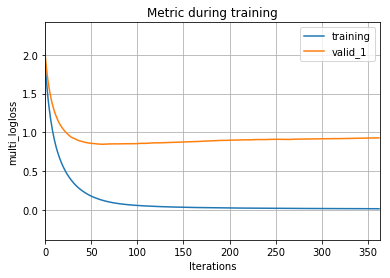

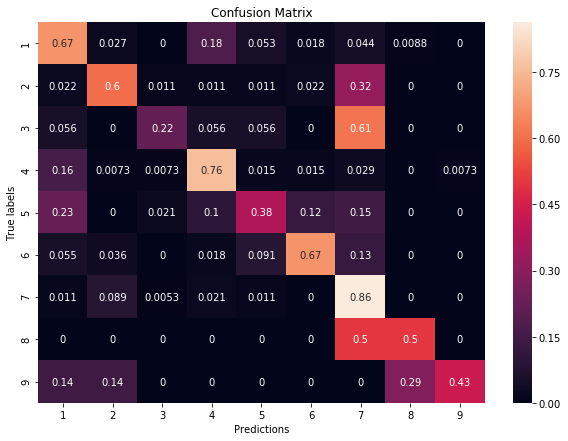

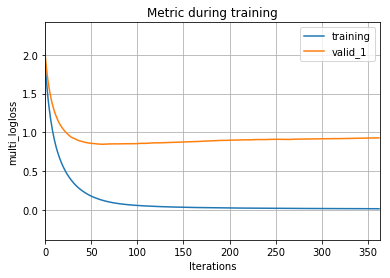

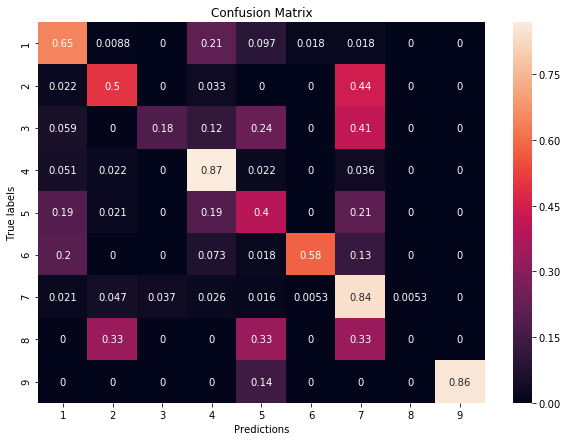

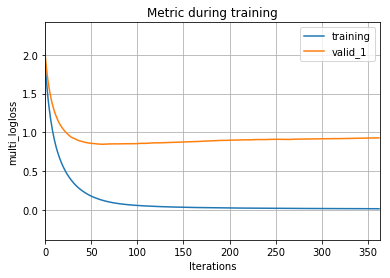

In [131]:
folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
X = tf_idf_X
Y = training_labels
skf_losses = []
f1s = []
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    X_train, y_train = SMOTE(ratio='minority', random_state=RANDOM_STATE).fit_sample(X_train, y_train)
    
    
    tf_idf_clf = lgb.LGBMClassifier(
                n_estimators= 10000, # will be stopped by early_stopping_rounds
                objective = 'multiclass',
                num_class = 9,
                )
    tf_idf_clf.fit(X_train, y_train, 
                    verbose = False,
                    early_stopping_rounds = 300,
                    eval_set= [(X_train, y_train), (X_test, y_test)])
    
    test_log_loss = log_loss(y_test, tf_idf_clf.predict_proba(X_test))
    f1 = f1_score(y_test, tf_idf_clf.predict(X_test), average='weighted')
    print(len(skf_losses), test_log_loss, f1)
    skf_losses.append(test_log_loss)
    f1s.append(f1)
    plot_confusion_matrix(tf_idf_clf, X_test, y_test)
    lgb.plot_metric(clf_random_resampled)
    
    y_submit = tf_idf_clf.predict_proba(tf_idf_X_submit, num_iteration=tf_idf_clf.best_iteration)
    submit_df = pd.DataFrame(y_submit, columns=['class'+str(i+1) for i in range(0,9)])
    submit_df.head()
    submit_df.index.name='ID'
    submit_df.to_csv('../submissions/'+str(test_log_loss)+'kaggle_submission_fold_'+str(len(skf_losses))+'.csv', sep=',')
    

In [128]:
print('avg. valid loss', np.mean(skf_losses))
print('avg. f1', np.mean(f1s))

avg. valid loss 0.908797985789
avg. f1 0.684424900956
